<a href="https://colab.research.google.com/github/sohamtalukdar/Segmentation-of-Kidneys-in-MRI/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
!pip install nibabel --upgrade
! pip install keras-unet-collection==0.1.13
!pip install keras-adabound
from keras_unet_collection import models
!pip install focal-loss
!pip install segmentation_models_3D
from keras_adabound import AdaBound
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import nibabel as nib
from nibabel.processing import conform
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import RMSprop
import random
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from keras import backend as K
from PIL import ImageOps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [117]:
"""Shamelessly taken from Alex Daniel - will cite properly!"""

def rescale(data, black=None, white=None):
    if black is None:
        black = np.mean(data) - 0.5 * np.std(data)
        if black < data.min():
            black = data.min()
    if white is None:
        white = np.mean(data) + 4 * np.std(data)
        if white > data.max():
            white = data.max()
    data = np.clip(data, black, white) - black
    data = data / (white - black)
    return data

def normalise_image(image, affine):

    image = rescale(image)
    img = nib.Nifti1Image(image, affine)
    zoom = img.header.get_zooms()
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, zoom[-1] * 0.998),
                  orientation='LIP')
    image = img.get_fdata()
    image = resize(image, (256, 256, image.shape[2]))
    zoom = img.header.get_zooms()
    return image
  
def normalise_mask(mask, affine):

    img = nib.Nifti1Image(mask, affine)
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, img.header.get_zooms()[-1] *
                              0.998),
                  orientation='LIP')
    mask = img.get_fdata()
    mask = resize(mask, (256, 256, mask.shape[2]))
    mask = np.round(mask)
    return mask

In [118]:
ground_truths = []
base_scans = []
dir = '/content/drive/MyDrive/ColabNotebooks/UNet/'
for f in sorted(os.listdir(dir + 'GroundTruth/')):
  image = nib.load(dir + 'GroundTruth/' + f)
  ground_truths.append(image)
for f in sorted(os.listdir(dir + 'Masks_T1/')):
  image = nib.load(dir + 'Masks_T1/'+ f)
  base_scans.append(image)
print(ground_truths[1].header.get_data_shape())


(256, 256, 17)


In [119]:
gt_arrays = []
gt_affine = []
base_arrays = []
base_affine = []
for img in ground_truths:
  affine = img.affine
  gt_voxels = img.get_fdata()
  normalised = normalise_mask(gt_voxels, affine)
  gt_arrays.append(normalised)
for img in base_scans:
  affine = img.affine
  base_voxels = img.get_fdata()
  normalised = normalise_image(base_voxels, affine)
  base_arrays.append(base_voxels)
pairs = zip(gt_arrays, base_arrays)

print(gt_arrays[1].shape)
print(len(gt_arrays), len(gt_affine))
print(type(base_arrays[2]))




(256, 256, 17)
10 0
<class 'numpy.ndarray'>


In [120]:
x_series = pd.Series(base_arrays)
y_series = pd.Series(gt_arrays)

#also courtesy of Alex Daniel

def tf_arrays(series):
    data = np.concatenate(series, 2)
    data = np.swapaxes(data, 0, 2)
    data = np.swapaxes(data, 1, 2)
    data = np.expand_dims(data, 3)
    return data

x_data = tf_arrays(x_series)
y_data = tf_arrays(y_series)
"""
for img in base_arrays:
  for i in range(0,17):
    x_images.append(img[:,:,i,np.newaxis])
for img in gt_arrays:
  for i in range(0,17):
    y_images.append(img[:,:,i,np.newaxis])
"""

print(len(x_data), len(y_data))
print(x_data[1].shape, y_data[1].shape)


"""
fig, ax = plt.subplots(2)
ax[0].imshow(x_images[46])
ax[1].imshow(y_images[46])
plt.show()
"""

170 170
(256, 256, 1) (256, 256, 1)


'\nfig, ax = plt.subplots(2)\nax[0].imshow(x_images[46])\nax[1].imshow(y_images[46])\nplt.show()\n'

In [208]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                     test_size = 0.3)

In [209]:
### UNET

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2



def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1


def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out


def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="softmax")(decoder_4)

    model = Model(input1, out)
    return model



In [210]:
# model = models.unet_2d((256, 256, 1), [64, 128, 256, 512, 1024], n_labels=3,
#                       stack_num_down=4, stack_num_up=4,
#                       activation='ReLU', output_activation='Softmax', 
#                       batch_norm=False, pool='max', unpool='nearest', name='unet')


In [211]:
input_shape = (256, 256,1)
model = U_Net(input_shape)

In [212]:
from focal_loss import SparseCategoricalFocalLoss
loss_func = SparseCategoricalFocalLoss(gamma=2)

model.compile(optimizer= Adam(learning_rate = 1e-4), 
              loss= "sparse_categorical_crossentropy"
              #loss= loss_func
              )

# Train the model, doing validation at the end of each epoch.

result = model.fit(x=x_train, 
                   y=y_train, 
                   batch_size=2, 
                   steps_per_epoch=len(x_train)//2,
                   epochs=100, 
                   validation_data=(x_valid, y_valid), 
                   )

Epoch 1/100
59/59 [==============================] - 8s 99ms/step - loss: 0.5139 - val_loss: 0.9542
Epoch 2/100
59/59 [==============================] - 5s 90ms/step - loss: 0.2030 - val_loss: 0.6836
Epoch 3/100
59/59 [==============================] - 5s 89ms/step - loss: 0.1496 - val_loss: 0.4269
Epoch 4/100
59/59 [==============================] - 5s 89ms/step - loss: 0.1206 - val_loss: 0.2636
Epoch 5/100
59/59 [==============================] - 5s 90ms/step - loss: 0.1008 - val_loss: 0.1864
Epoch 6/100
59/59 [==============================] - 5s 90ms/step - loss: 0.0849 - val_loss: 0.1399
Epoch 7/100
59/59 [==============================] - 5s 89ms/step - loss: 0.0781 - val_loss: 0.1158
Epoch 8/100
59/59 [==============================] - 5s 89ms/step - loss: 0.0670 - val_loss: 0.0897
Epoch 9/100
59/59 [==============================] - 5s 90ms/step - loss: 0.0625 - val_loss: 0.0879
Epoch 10/100
59/59 [==============================] - 5s 89ms/step - loss: 0.0561 - val_loss: 0.0718

2/2 [==============================] - 0s 174ms/step - loss: 0.0439


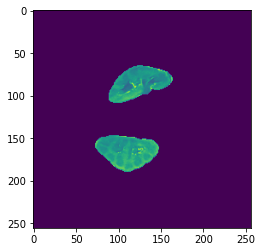

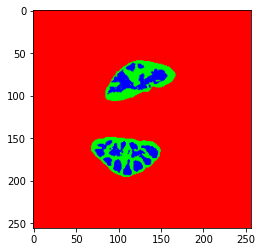

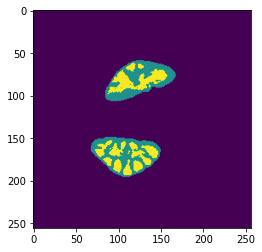

In [218]:
model.evaluate(x_valid, y_valid)
predicted_masks = model.predict(x_train)
plt.show()
#FOR T2 - 20,14,12,11,6,5,3,2( 12 ): 2,3,4,8
#FOR T1 - 20,18,16,12,11,10,7,6,5,4
i = 20
plt.imshow(np.squeeze(x_train[i]))
plt.show()
# plt.imshow(np.squeeze(y_train[i]))
# plt.show()
plt.imshow(np.squeeze(predicted_masks[i]))
plt.show()


def display_mask(j):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(predicted_masks[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    #display(img)
    plt.imshow(np.squeeze(mask))
    plt.show()

display_mask(predicted_masks[i])
